<a href="https://colab.research.google.com/github/sahilmehtx/ECE539_Project/blob/main/ECE539_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


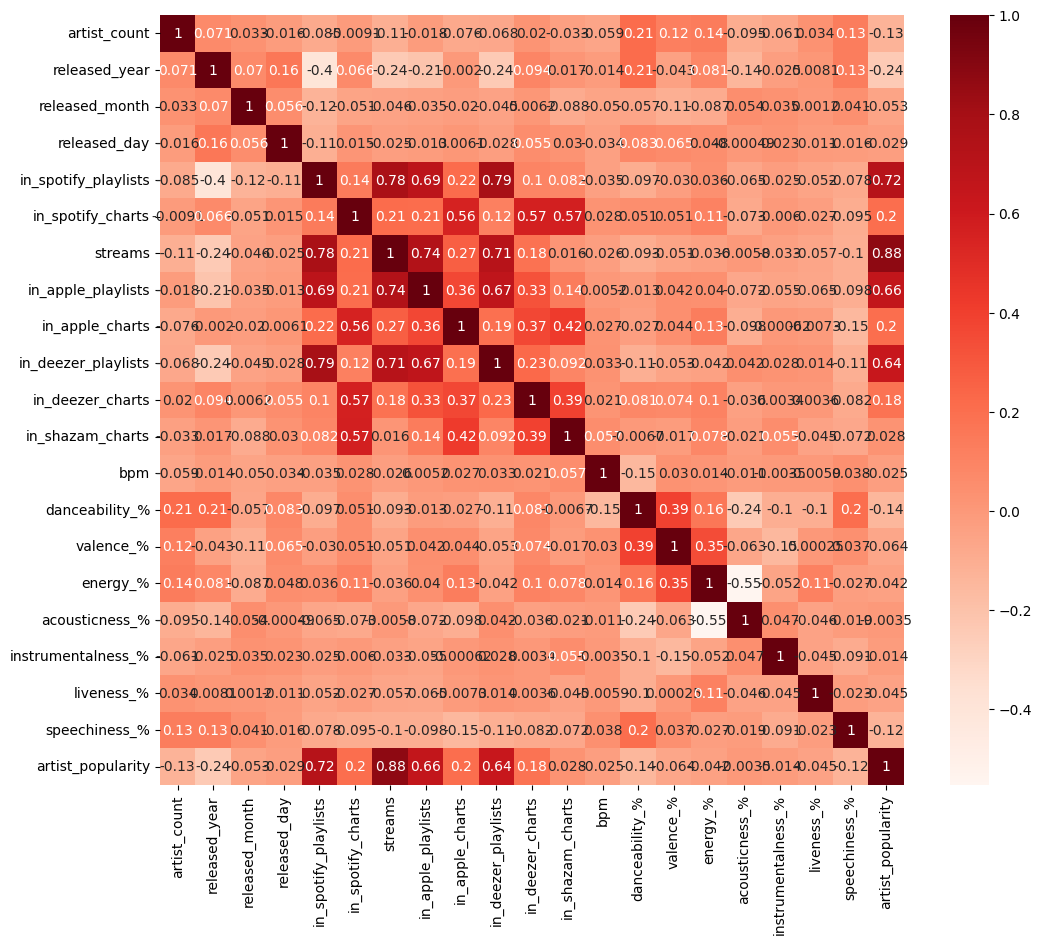

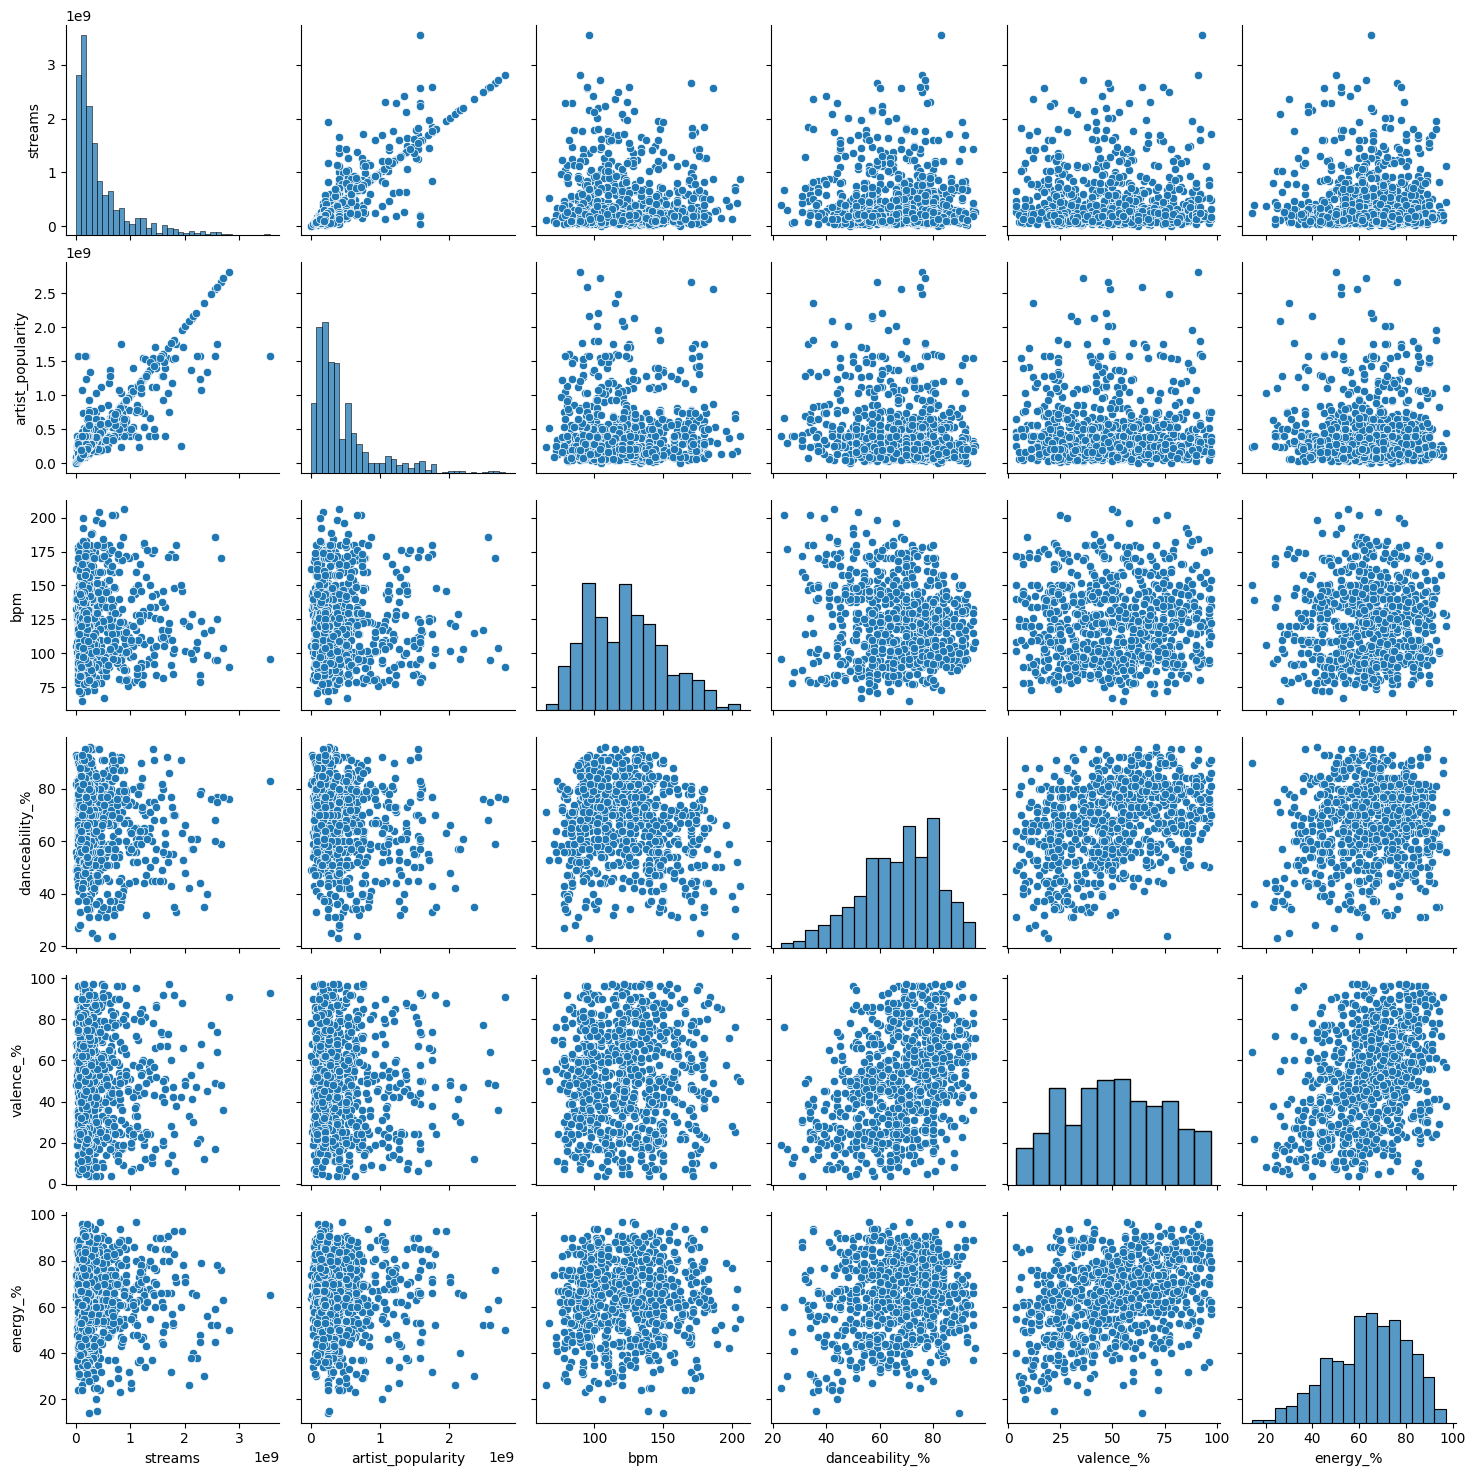

Linear Regression:
RMSE: 544931461.47
MAE: 391276191.38
R-squared: 0.03

Random Forest:
RMSE: 570999283.20
MAE: 406181199.21
R-squared: -0.06

Gradient Boosting:
RMSE: 574527087.43
MAE: 404208551.18
R-squared: -0.08

Linear Regression - Cross-validation RMSE scores: [7.55608707e+08 4.24765481e+08 4.15915664e+08 6.13195837e+08
 3.60889041e+08]
Linear Regression - Average RMSE score: 514074945.96 (+/- 147811268.57)

Random Forest - Cross-validation RMSE scores: [7.43552017e+08 4.58906917e+08 4.73863264e+08 6.10828230e+08
 4.34784787e+08]
Random Forest - Average RMSE score: 544387043.13 (+/- 116939495.57)

Gradient Boosting - Cross-validation RMSE scores: [7.29653656e+08 4.75606744e+08 4.55426415e+08 6.46513150e+08
 4.01652847e+08]
Gradient Boosting - Average RMSE score: 541770562.49 (+/- 124689216.31)



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
data = pd.read_csv('Popular_Spotify_Songs.csv', encoding='latin-1')

# DATA PREPROCESSING
# Handle missing values
data.dropna(inplace=True)  # Remove rows with missing values

# Remove rows with non-numeric values in the 'streams' column
data = data[data['streams'].str.replace(',', '').str.isdigit()]

# Convert 'streams' column to float
data['streams'] = data['streams'].str.replace(',', '').astype(float)

# Clean the 'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts' columns
data['in_spotify_playlists'] = pd.to_numeric(data['in_spotify_playlists'], errors='coerce')
data['in_spotify_charts'] = pd.to_numeric(data['in_spotify_charts'], errors='coerce')
data['in_apple_playlists'] = pd.to_numeric(data['in_apple_playlists'], errors='coerce')
data['in_apple_charts'] = pd.to_numeric(data['in_apple_charts'], errors='coerce')
data['in_deezer_playlists'] = pd.to_numeric(data['in_deezer_playlists'], errors='coerce')
data['in_deezer_charts'] = pd.to_numeric(data['in_deezer_charts'], errors='coerce')
data['in_shazam_charts'] = data['in_shazam_charts'].str.replace(',', '').astype(float)

# Encode categorical variables
cat_features = []
num_features = ['bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']  # Replace with your numerical features

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

# Create a feature for artist popularity
data['artist_popularity'] = data.groupby('artist(s)_name')['streams'].transform('mean')

# Create a feature for genre diversity
# data['genre_diversity'] = data.groupby('artist(s)_name')['genre'].transform('nunique')

# EXPLORATORY DATA ANALYSIS (EDA)
# Correlation matrix=
plt.figure(figsize=(12, 10))
cor = data.drop(['track_name', 'artist(s)_name', 'key', 'mode'], axis=1).corr()  # Exclude 'track_name', 'artist(s)_name', 'key', and 'mode' columns
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Pairplot to visualize relationships
sns.pairplot(data, vars=['streams', 'artist_popularity', 'bpm', 'danceability_%', 'valence_%', 'energy_%'])
plt.show()

# MODEL DEVELOPMENT=
# Split data into features and target
X = data.drop(['track_name', 'artist(s)_name', 'streams', 'key', 'mode'], axis=1)
y = data['streams']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipelines for different models
models = [
    ('Linear Regression', Pipeline([('preprocessor', preprocessor), ('classifier', LinearRegression())])),
    ('Random Forest', Pipeline([('preprocessor', preprocessor), ('classifier', RandomForestRegressor())])),
    ('Gradient Boosting', Pipeline([('preprocessor', preprocessor), ('classifier', GradientBoostingRegressor())]))
]

# MODEL EVALUATION
# Evaluate each model
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name}:")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"R-squared: {r2_score(y_test, y_pred):.2f}\n")

# Cross-validation
for name, model in models:
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"{name} - Cross-validation RMSE scores: {np.sqrt(-scores)}")
    print(f"{name} - Average RMSE score: {np.sqrt(-scores).mean():.2f} (+/- {np.sqrt(-scores).std():.2f})\n")